In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import numpy as np

from matplotlib.cm import ScalarMappable
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image

[Divvy](https://www.divvybikes.com/) is Chicago's bike share program which works the same way as NYC's [Citi Bike](https://www.citibikenyc.com/) and Washington DC's [Capital Bikeshare](https://www.capitalbikeshare.com/).  You undock a bike from a station, ride it for 30 minutes until you dock it back into any station, with a fee.

It's a great way to get from point A to B, but I usually ride them during summertime along Lake Michigan, which is absolutely ***GLORIOUS***.  Below is a picture I took when me and my friends went on for a ride.

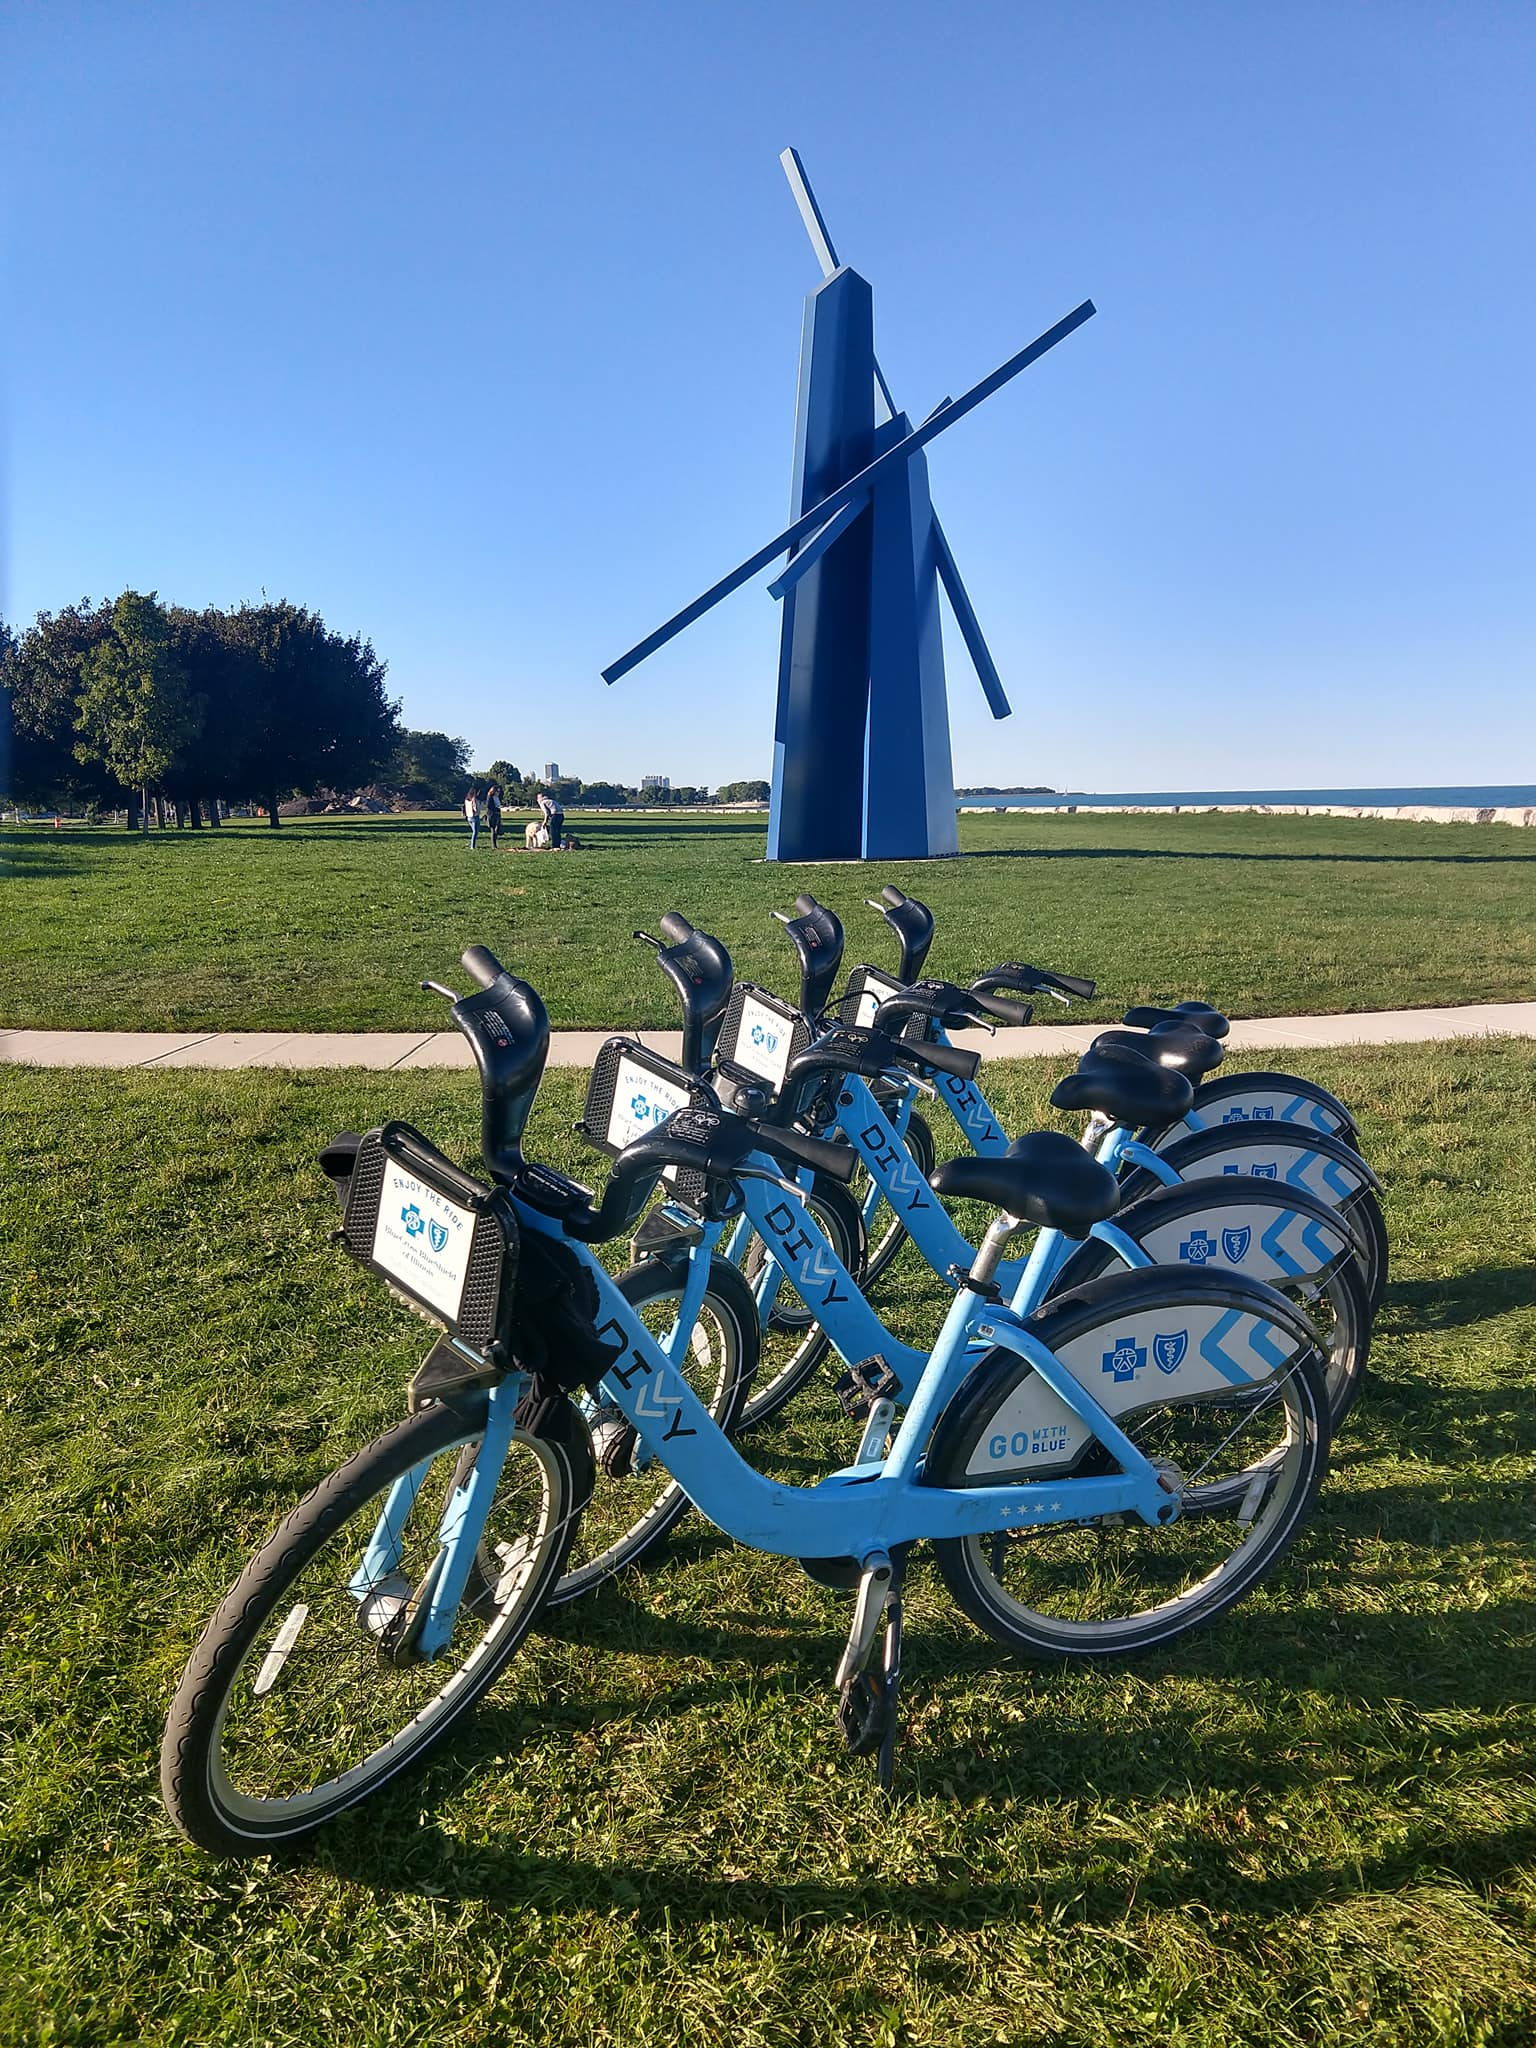

In [3]:
# show Divvy image
Image(filename='/Users/ncho/git/lacolombe-nowifi/etl/divvy_michigan.jpg', width = 300)

Divvy exposes a [JSON feed](https://feeds.divvybikes.com/stations/stations.json) online, which seems to update every few seconds on how many bikes are available in all the stations in real time.  This seemed like interesting data, so I collected for ~24 hours starting from Monday, October 8th, 2018 and started peaking in for any interesting patterns.

In [3]:
# import scraped json feed data
df = pd.read_csv("/Users/ncho/git/lacolombe-nowifi/etl/test.csv").query("id != 'id'")
df[['availableBikes', 'totalDocks']] = df[['availableBikes', 'totalDocks']].astype('float')
df['lastCommunicationTime'] = pd.to_datetime(df['lastCommunicationTime'])

In [4]:
# create summary station
summary_station = df.groupby(['id', 'stationName'])[['totalDocks', 'longitude', 'latitude']].max().astype(float)

<br/>
## How large are the stations, and where are the largest stations?<br/>

There are **588 stations** that are operational as of October 8th, 2018 and the **median dock count is 15**(station size).  If you're Divvy station has more than 15 docks, now you know that you're at a relatively larger station or not.

Also, histrogram of station dock counts below shows that the majority of the stations are smaller than 20 docks.  Specifically, **~80% (470) of stations have fewer than 20 docks**.

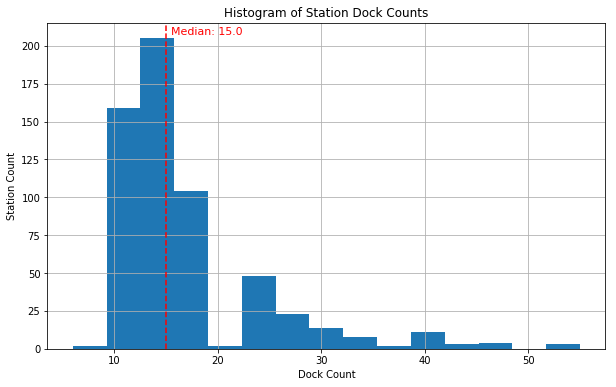

In [5]:
ax = summary_station['totalDocks'].hist(bins = 15, figsize = (10,6))
plt.title("Histogram of Station Dock Counts")
ax.set_xlabel("Dock Count")
ax.set_ylabel("Station Count");

median = summary_station['totalDocks'].median()
plt.axvline(median, c = 'red', linestyle = '--')
plt.text(median + 0.5,207.5, "Median: {}".format(median), fontsize = 11, color = 'red');

Moving onto the bigger stations, there are exactly 10 stations that has more than 40 docks as below.  The largest stations have 55 docks and there are 3 stations with this many docks available.

In [6]:
# show stations with more than 40 docks
top_cnt = summary_station.loc[summary_station['totalDocks'] >= 40]\
    .sort_values('totalDocks', ascending = False)\
    .reset_index()[['stationName', 'totalDocks']]
top_cnt.columns = ['station name', 'total docks']
top_cnt

station name  total docks
0      Columbus Dr & Randolph St         55.0
1                 Shedd Aquarium         55.0
2                   Field Museum         55.0
3            Canal St & Adams St         47.0
4  Ravenswood Ave & Lawrence Ave         47.0
5        Streeter Dr & Grand Ave         47.0
6                Millennium Park         47.0
7   Michigan Ave & Washington St         43.0
8     Larrabee St & Kingsbury St         43.0
9          Michigan Ave & 8th St         42.0

As expected, most of these stations are located in the downtown Chicago area, except for the [Ravenswood Ave & Lawrence](https://www.google.com/maps/place/Divvy+Station:+Ravenswood+Ave+%26+Lawrence+Ave/@41.9690647,-87.6741959,3a,75y,260.11h,90t/data=!3m7!1e1!3m5!1sNJ47KNZ-sIN2KJHE8rpdSw!2e0!6s%2F%2Fgeo3.ggpht.com%2Fcbk%3Fpanoid%3DNJ47KNZ-sIN2KJHE8rpdSw%26output%3Dthumbnail%26cb_client%3Dsearch.TACTILE.gps%26thumb%3D2%26w%3D234%26h%3D106%26yaw%3D260.11026%26pitch%3D0%26thumbfov%3D100!7i13312!8i6656!4m8!1m2!2m1!1sdivvy+Ravenswood+Ave+%26+Lawrence!3m4!1s0x880fd223bd912f4f:0x491bfb46039d36dd!8m2!3d41.9690567!4d-87.674241) Ave and [Larrabee St & Kingsbury St](https://www.google.com/maps/place/N+Kingsbury+St+%26+N+Larrabee+St,+Chicago,+IL+60610/@41.8977745,-87.6429428,3a,75y,187.5h,90t/data=!3m7!1e1!3m5!1syF7jeG18zexd9_SrVc-dLg!2e0!6s%2F%2Fgeo3.ggpht.com%2Fcbk%3Fpanoid%3DyF7jeG18zexd9_SrVc-dLg%26output%3Dthumbnail%26cb_client%3Dsearch.TACTILE.gps%26thumb%3D2%26w%3D86%26h%3D86%26yaw%3D187.4999%26pitch%3D0%26thumbfov%3D100!7i16384!8i8192!4m5!3m4!1s0x880fd3348132faf9:0x8bc5db7cbbbbc56e!8m2!3d41.897778!4d-87.6430376) station.  

The Ravenswood station features a double-sided docking design and the Larrabee station seems to be next by the Groupon HQ based on Google Street View images.  Not sure why there are huge stations there, but these might be locations with high foot-traffic outside of downtown Chicago.  Might be worth checking out once Chicago turns warmer.

In [7]:
# normalize data for use in heatmap drawing
start_time = pd.to_datetime('2018-10-08 07:57:15')
heatmap_df = df[['id', 'lastCommunicationTime', 'availableBikes', 'totalDocks']]\
    .pivot_table(values = ['availableBikes', 'totalDocks']
                 , index = ['lastCommunicationTime']
                 , columns = 'id')\
    .sort_index()\
    .ffill()\
    .loc[start_time:,:]\
    .stack()\
    .reset_index()\
    .set_index('lastCommunicationTime')\
    .groupby('id')\
    .resample('600s')\
    .mean()\
    .reset_index()\
    .merge(summary_station.reset_index()[['id', 'stationName', 'longitude', 'latitude']]
                                , on = 'id')\
    .sort_values('lastCommunicationTime')\
    .set_index('lastCommunicationTime')

In [8]:
%%capture
# data points/values needed for template heatmap
map_coord = summary_station.agg([min, max])
fig, ax = plt.subplots(1,2,figsize = (10,8))

ax[0].set_title("All")
ax[1].set_title("Downtown Area")

m = Basemap(llcrnrlon=map_coord.loc['min', 'longitude']
            ,llcrnrlat=map_coord.loc['min', 'latitude']
            ,urcrnrlon=map_coord.loc['max', 'longitude']
            ,urcrnrlat=map_coord.loc['max', 'latitude'], ax = ax[0])

m2 = Basemap(llcrnrlon=-87.665438
            ,llcrnrlat=41.839211
            ,urcrnrlon=-87.608469
            ,urcrnrlat=41.922997, ax = ax[1])

data = heatmap_df.loc[heatmap_df.index.unique()[0]]
x, y = m(data['longitude'], data['latitude'])
color = data['availableBikes']
size = data['totalDocks']
cmap = plt.cm.YlOrRd
sm = ScalarMappable(cmap=cmap)

In [9]:
# draw template for heatmap where data will be updated for animation
title = fig.text(0.45,0.9,"")

m.drawmapboundary(zorder=0)
m.drawcounties(facecolor = 'grey')

m2.drawmapboundary(zorder=0)
m2.drawcounties(facecolor = 'grey')

scatter = m.scatter(x,y,s=size,c=color,cmap=cmap,alpha=0.3,edgecolors='face',marker='H',vmax=5,vmin=0,zorder=1.5)
scatter2 = m2.scatter(x,y,s=size,c=color,cmap=cmap,alpha=0.3,edgecolors='face',marker='H',vmax=5,vmin=0,zorder=1.5)

# function to update heatmap
def update(ts):
    data = heatmap_df.loc[ts]
    new_offset = data[['longitude', 'latitude']].values
    color = data['availableBikes']
    size = data['totalDocks']
    scatter.set_offsets(new_offset)
    scatter.set_color(sm.to_rgba(color))
    scatter.set_sizes(size)
    
    scatter2.set_offsets(new_offset)
    scatter2.set_color(sm.to_rgba(color))
    scatter2.set_sizes(size)
    title.set_text(ts)
    return scatter,

In [9]:
# generage heatmap and save
anim = FuncAnimation(fig,update,interval=100,repeat=False,frames=heatmap_df.index.unique(),blit=True)
anim.save('divvy_heatmap.gif', writer='imagemagick')

<br/>
## Where are the bikes parked throughout Monday?

Below is an animated **heatmap of where bikes are parked in 10 minute intervals**.  This might reveal some interesting travel patterns that show how people are using Divvy bikes.  Each circle is a station, where red indicates more bikes parked and ligher yellow indicates fewer bikes.  Also, larger circles indicate bigger stations with more docking spots.

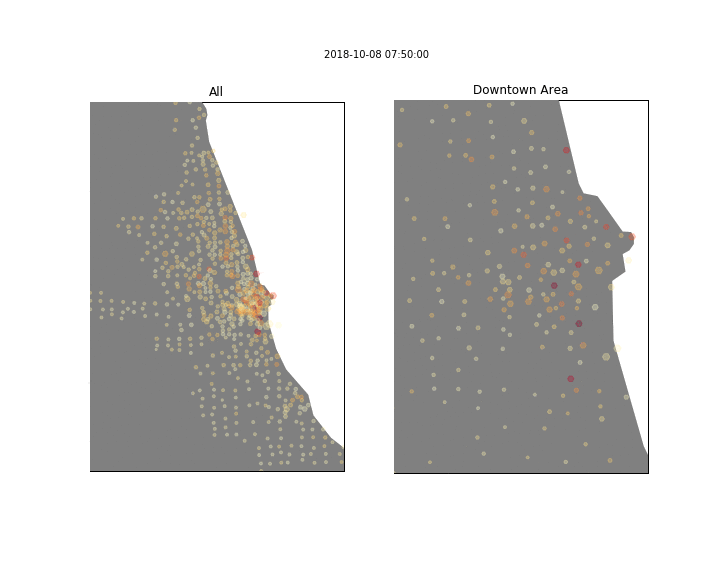

In [6]:
Image(filename = '/Users/ncho/git/lacolombe-nowifi/etl/divvy_heatmap.gif')

There are a few patterns we can observe:

  - The day starts off with a lot of bikes (red) parked in the downtown Chicago area.
  - The heat (red) starts to clear out a little from the eastern side of downtown Chicago since start of day.
  - More heat (red) clears out of downtown Chicago to north and northwest neighborhoods starting from 4:00pm.

All in all, people seem to use Divvy (decrease in red) actively in the eastern part of downtown Chicago staring from earlier in the day, followed by a lot of bikes in downtown Chicago flushing out to north and northwest neighborhoods around commute time.

<br/>
## Trends in total bikes available in Divvy 
Below is a chart that sums up the activity observed in the heatmap above across all stations in the Divvy system.  More specifically, the total number of bikes parked in all stations are shown over time.

The reason for two lines corresponding to min/max is because a station could report different numbers of bikes parked in a 1 second interval (least time measurement unit for Divvy) when there is high activity.  Grey area shows the difference of the min/max lines, which could tell us how actively bikes docked and undocked in single stations (single-station busyness).

In [12]:
ts = df.groupby(['id', 'lastCommunicationTime'])[['availableBikes', 'totalDocks']].agg(['size', 'min', 'max'])
summary = ts.unstack(0).sort_index().ffill()

count_summary = summary[('availableBikes', 'size')].notna().sum(axis = 1)
start_time = count_summary[count_summary==count_summary.max()].index.min()
master = summary.loc[start_time:, summary.columns.get_level_values(1).isin(['min', 'max'])]

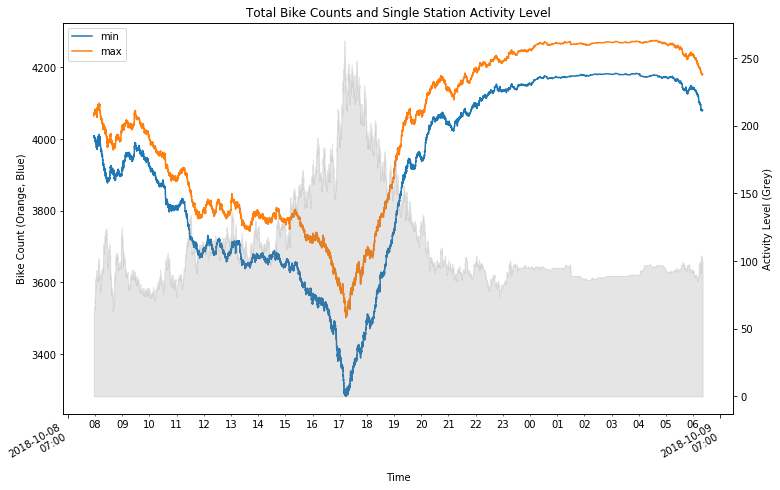

In [13]:
# activity chart
summary_bikes = master.groupby(level = [0,1], axis = 1).sum()['availableBikes']
ax = summary_bikes.plot(title = "Total Bike Counts and Single Station Activity Level", figsize = (12,8))
ax2 = ax.twinx()
ax2.fill_between(summary_bikes.index
                 , 0
                 , summary_bikes['max'] - summary_bikes['min']
                 , color = 'grey'
                 , alpha = 0.2)

# format axes labels
ax.set_xlabel("Time")
ax.set_ylabel("Bike Count (Orange, Blue)")
ax2.set_ylabel("Activity Level (Grey)")

# format x-axis
ax.xaxis.set_major_locator(mdate.HourLocator(7))
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d\n%H:%M'))
ax.xaxis.set_minor_locator(mdate.HourLocator([n for n in range(25) if n not in [7]]))
ax.xaxis.set_minor_formatter(mdate.DateFormatter('%H'))

Consistent with what we observed from the heatmap, we see the number of bikes available decrease from start of day until  12:00pm (both the min/max lines).  This drawdown might be driven by the heat clearing out from the eastern part of downtown Chicago in the heatmap.

After this comes a drastic dip in bike count from 4:00pm, followed by a spike up until 8:00pm.  I'm pretty sure that this pattern is driven by the heat flushing out of downtown Chicago and spreading to north and northwest neighborhoods in the heatmap.

Single station busyness (grey area) spikes up when the number of bikes dip down to minimum shortly after 5:00pm, meaning that this is an extremely busy time, where people are not only using Divvy bikes a lot, but also docking and undocking very frequently.

We've seen a few charts, and have a few hypothesis for the patterns that we see in them so far:
- **Hypothesis 1: Decrease in bike count from morning until 12:00pm is driven by high usage patterns in eastern downtown Chicago stations.**
- **Hypothesis 2: Dip and spike in bike count starting from 4:00pm are caused by commuters going home from downtown Chicago to north and northwest neighborhoods.**

<br/>
In part 2, I'll start looking into station level patterns that are driving the overall trend in the chart above to verify the hypotheses I established and dig out other interesting patterns.

Hope you enjoyed reading and stay tuned to see if my guesses are correct :)

<br/>
## More

Python script to download json feed from Divvy, click [here](https://github.com/lacolombe-nowifi/etl/blob/dev/scrape_divvy_rss_feed.py).

Jupyter notebook for analysis in this post, click [here](https://github.com/ncho-sqd/ncho-sqd.github.io/blob/master/original_posts/analyze_divvy_rss_feed_part1.ipynb).